In [138]:
!pip install tensorflow==2.13.0
!pip install tensorflow_addons
!pip install keras

In [139]:
!pip install tensorflow==2.13.0
!pip install tensorflow_addons
!pip install keras

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sn

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, GroupShuffleSplit

import glob
import sys
import os
import math
import gc
import sys
import sklearn
import scipy

In [140]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [141]:
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 20

In [142]:
# we will preprocess once if working on local machine, always if kaggle or other online ide
PREPROCESS_DATA = True
TRAIN_MODEL = True
# False: use 10% of participants as validation set. we do not use it normally
# utilize full as train set. So setting it as False
USE_VAL = False

N_ROWS = 543
N_DIMS = 3
DIM_NAMES = ['x', 'y', 'z']
SEED = 20
NUM_CLASSES = 50 # this is class number, you must change it according to dataset
VERBOSE = 2

INPUT_SIZE = 12 #or 24

BATCH_ALL_SIGNS_N = 1
BATCH_SIZE = 16
N_EPOCHS = 300
LR_MAX = 1e-3
N_WARMUP_EPOCHS = 0
WD_RATIO = 0.05
MASK_VAL = 437

N_MODELS = 4  # train 4 models
DEBUG = False

In [143]:
# Prints Shape and Dtype For List Of Variables
def print_shape_dtype(l, names):
    for e, n in zip(l, names):
        print(f'{n} shape: {e.shape}, dtype: {e.dtype}')

In [144]:
videos = pd.read_csv('/content/drive/MyDrive/SIGN/Documentos/video_details.csv') # notice if this is correctly set

train = videos[videos['Type']=='train']
train.drop('Unnamed: 0', axis=1, inplace=True)

# assign number to each sign name
train['sign_ord'] = train['Label'].astype('category').cat.codes

# Dictionaries to translate sign <-> ordinal encoded sign
SIGN2ORD = train[['Label', 'sign_ord']].set_index('Label').squeeze().to_dict()
ORD2SIGN = train[['sign_ord', 'Label']].set_index('sign_ord').squeeze().to_dict()

train.columns = ['file_path', 'participant_id', 'sign', 'Type', 'sign_ord']
train['path'] = train['file_path']

train = train[train.file_path != '/content/drive/MyDrive/SIGN/Dataset_processed/train/Cabeca/Cabeca_2.parquet']
train = train[train.file_path != '/content/drive/MyDrive/SIGN/Dataset_processed/train/BomDia/BomDia_3.parquet']

N_SAMPLES = len(train)
print(f'N_SAMPLES: {N_SAMPLES}')

N_SAMPLES: 177


<ipython-input-144-69ee847b05ef>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop('Unnamed: 0', axis=1, inplace=True)
<ipython-input-144-69ee847b05ef>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['sign_ord'] = train['Label'].astype('category').cat.codes
<ipython-input-144-69ee847b05ef>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

In [145]:
# # Get complete file path to file
# def get_file_path(path):
#     return f'/kaggle/input/include-50-final/INCLUDE50/{path}' # notice if this is correctly set

# train['file_path'] = train['path'].apply(get_file_path)

In [146]:
display(train.head(30))
display(train.info())

,file_path,participant_id,sign,Type,sign_ord,path
70,/content/drive/MyDrive/SIGN/Dataset_processed/...,Engenharia_1.parquet,Engenharia,train,38,/content/drive/MyDrive/SIGN/Dataset_processed/...
71,/content/drive/MyDrive/SIGN/Dataset_processed/...,Engenharia_2.parquet,Engenharia,train,38,/content/drive/MyDrive/SIGN/Dataset_processed/...
72,/content/drive/MyDrive/SIGN/Dataset_processed/...,Trabalho_1.parquet,Trabalho,train,64,/content/drive/MyDrive/SIGN/Dataset_processed/...
73,/content/drive/MyDrive/SIGN/Dataset_processed/...,Trabalho_2.parquet,Trabalho,train,64,/content/drive/MyDrive/SIGN/Dataset_processed/...
74,/content/drive/MyDrive/SIGN/Dataset_processed/...,Trabalho_3.parquet,Trabalho,train,64,/content/drive/MyDrive/SIGN/Dataset_processed/...
75,/content/drive/MyDrive/SIGN/Dataset_processed/...,Trabalho_4.parquet,Trabalho,train,64,/content/drive/MyDrive/SIGN/Dataset_processed/...
76,/content/drive/MyDrive/SIGN/Dataset_processed/...,Trabalho_5.parquet,Trabalho,train,64,/content/drive/MyDrive/SIGN/Dataset_processed/...
77,/content/drive/MyDrive/SIGN/Dataset_processed/...,Trabalho_6.parquet,Trabalho,train,64,/content/drive/MyDrive/SIGN/Dataset_processed/...
78,/content/drive/MyDrive/SIGN/Dataset_processed/...,Trabalho_7.parquet,Trabalho,train,64,/content/drive/MyDrive/SIGN/Dataset_processed/...
79,/content/drive/MyDrive/SIGN/Dataset_processed/...,CeuAzul_1.parquet,CeuAzul,train,25,/content/drive/MyDrive/SIGN/Dataset_processed/...


<class 'pandas.core.frame.DataFrame'>
Index: 177 entries, 70 to 248
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   file_path       177 non-null    object
 1   participant_id  177 non-null    object
 2   sign            177 non-null    object
 3   Type            177 non-null    object
 4   sign_ord        177 non-null    int8  
 5   path            177 non-null    object
dtypes: int8(1), object(5)
memory usage: 8.5+ KB


None

In [147]:
#change N as desired
N = int(3e3) if (not PREPROCESS_DATA) else int(10e3)
N_UNIQUE_FRAMES = np.zeros(N, dtype=np.uint16)
N_MISSING_FRAMES = np.zeros(N, dtype=np.uint16)
MAX_FRAME = np.zeros(N, dtype=np.uint16)

PERCENTILES = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99, 0.999]

for idx, file_path in enumerate(tqdm(train['file_path'])):
    df = pd.read_parquet(file_path)
    N_UNIQUE_FRAMES[idx] = df['frame'].nunique()
    N_MISSING_FRAMES[idx] = (df['frame'].max() - df['frame'].min()) - df['frame'].nunique() + 1
    MAX_FRAME[idx] = df['frame'].max()

  0%|          | 0/177 [00:00<?, ?it/s]

In [148]:
ROWS_PER_FRAME = 543  # number of landmarks per frame (total holistic keypoints)

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [149]:
class PreprocessLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(PreprocessLayer, self).__init__()

    def pad_edge(self, t, repeats, side):
        if side == 'LEFT':
            return tf.concat((tf.repeat(t[:1], repeats=repeats, axis=0), t), axis=0)
        elif side == 'RIGHT':
            return tf.concat((t, tf.repeat(t[-1:], repeats=repeats, axis=0)), axis=0)

    @tf.function(
        input_signature=(tf.TensorSpec(shape=[None,N_ROWS,N_DIMS], dtype=tf.float32),),
    )
    def call(self, data0):
        # Number of Frames in Video
        N_FRAMES0 = tf.shape(data0)[0]

        # Filter Out Frames With Empty Hand Data
        frames_hands_nansum = tf.experimental.numpy.nanmean(tf.gather(data0, HAND_IDXS0, axis=1), axis=[1,2])
        non_empty_frames_idxs = tf.where(frames_hands_nansum > 0)
        non_empty_frames_idxs = tf.squeeze(non_empty_frames_idxs, axis=1)
        data = tf.gather(data0, non_empty_frames_idxs, axis=0)

        # Cast Indices in float32 to be compatible with Tensorflow Lite
        non_empty_frames_idxs = tf.cast(non_empty_frames_idxs, tf.float32)


        # Number of Frames in Filtered Video
        N_FRAMES = tf.shape(data)[0]

        # Gather Relevant Landmark Columns
        data = tf.gather(data, LANDMARK_IDXS0, axis=1)

        # Video fits in INPUT_SIZE
        if N_FRAMES < INPUT_SIZE:
            # Pad With -1 to indicate padding
            non_empty_frames_idxs = tf.pad(non_empty_frames_idxs, [[0, INPUT_SIZE-N_FRAMES]], constant_values=-1)
            # Pad Data With Zeros
            data = tf.pad(data, [[0, INPUT_SIZE-N_FRAMES], [0,0], [0,0]], constant_values=0)
            # Fill NaN Values With 0
            data = tf.where(tf.math.is_nan(data), 0.0, data)
            return data, non_empty_frames_idxs
        # Video needs to be downsampled to INPUT_SIZE
        else:
            # Repeat
            if N_FRAMES < INPUT_SIZE**2:
                repeats = tf.math.floordiv(INPUT_SIZE * INPUT_SIZE, N_FRAMES0)
                data = tf.repeat(data, repeats=repeats, axis=0)
                non_empty_frames_idxs = tf.repeat(non_empty_frames_idxs, repeats=repeats, axis=0)

            # Pad To Multiple Of Input Size
            pool_size = tf.math.floordiv(len(data), INPUT_SIZE)
            if tf.math.mod(len(data), INPUT_SIZE) > 0:
                pool_size += 1

            if pool_size == 1:
                pad_size = (pool_size * INPUT_SIZE) - len(data)
            else:
                pad_size = (pool_size * INPUT_SIZE) % len(data)

            # Pad Start/End with Start/End value
            pad_left = tf.math.floordiv(pad_size, 2) + tf.math.floordiv(INPUT_SIZE, 2)
            pad_right = tf.math.floordiv(pad_size, 2) + tf.math.floordiv(INPUT_SIZE, 2)
            if tf.math.mod(pad_size, 2) > 0:
                pad_right += 1

            # Pad By Concatenating Left/Right Edge Values
            data = self.pad_edge(data, pad_left, 'LEFT')
            data = self.pad_edge(data, pad_right, 'RIGHT')

            # Pad Non Empty Frame Indices
            non_empty_frames_idxs = self.pad_edge(non_empty_frames_idxs, pad_left, 'LEFT')
            non_empty_frames_idxs = self.pad_edge(non_empty_frames_idxs, pad_right, 'RIGHT')

            # Reshape to Mean Pool
            data = tf.reshape(data, [INPUT_SIZE, -1, N_COLS, N_DIMS])
            non_empty_frames_idxs = tf.reshape(non_empty_frames_idxs, [INPUT_SIZE, -1])

            # Mean Pool
            data = tf.experimental.numpy.nanmean(data, axis=1)
            non_empty_frames_idxs = tf.experimental.numpy.nanmean(non_empty_frames_idxs, axis=1)

            # Fill NaN Values With 0
            data = tf.where(tf.math.is_nan(data), 0.0, data)

            return data, non_empty_frames_idxs

preprocess_layer = PreprocessLayer()

In [150]:
"""
    face: 0:468
    left_hand: 468:489
    pose: 489:522
    right_hand: 522:544

"""
def get_data(file_path):
    # Load Raw Data
    data = load_relevant_data_subset(file_path)
    # Process Data Using Tensorflow
    data = preprocess_layer(data)

    return data

In [151]:
#choose they keypoints you want to embed. We choose only lips from face
USE_TYPES = ['left_hand', 'pose', 'right_hand']
START_IDX = 468
LIPS_IDXS0 = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])
# Landmark indices in original data
LEFT_HAND_IDXS0 = np.arange(468,489)
RIGHT_HAND_IDXS0 = np.arange(522,543)
POSE_IDXS0 = np.arange(502, 512)
LANDMARK_IDXS0 = np.concatenate((LIPS_IDXS0, LEFT_HAND_IDXS0, RIGHT_HAND_IDXS0, POSE_IDXS0))
HAND_IDXS0 = np.concatenate((LEFT_HAND_IDXS0, RIGHT_HAND_IDXS0), axis=0)
N_COLS = LANDMARK_IDXS0.size
# Landmark indices in processed data
LIPS_IDXS = np.argwhere(np.isin(LANDMARK_IDXS0, LIPS_IDXS0)).squeeze()
LEFT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS0, LEFT_HAND_IDXS0)).squeeze()
RIGHT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS0, RIGHT_HAND_IDXS0)).squeeze()
HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS0, HAND_IDXS0)).squeeze()
POSE_IDXS = np.argwhere(np.isin(LANDMARK_IDXS0, POSE_IDXS0)).squeeze()

print(f'# HAND_IDXS: {len(HAND_IDXS)}, N_COLS: {N_COLS}')

# HAND_IDXS: 42, N_COLS: 92


In [152]:
LIPS_START = 0
LEFT_HAND_START = LIPS_IDXS.size
RIGHT_HAND_START = LEFT_HAND_START + LEFT_HAND_IDXS.size
POSE_START = RIGHT_HAND_START + RIGHT_HAND_IDXS.size

print(f'LIPS_START: {LIPS_START}, LEFT_HAND_START: {LEFT_HAND_START}, RIGHT_HAND_START: {RIGHT_HAND_START}, POSE_START: {POSE_START}')

LIPS_START: 0, LEFT_HAND_START: 40, RIGHT_HAND_START: 61, POSE_START: 82


In [153]:
# Get the full dataset
def preprocess_data():
    # Create arrays to save data
    X = np.zeros([N_SAMPLES, INPUT_SIZE, N_COLS, N_DIMS], dtype=np.float32)
    y = np.zeros([N_SAMPLES], dtype=np.int32)
    NON_EMPTY_FRAME_IDXS = np.full([N_SAMPLES, INPUT_SIZE], -1, dtype=np.float32)

    # Fill X/y
    for row_idx, (file_path, sign_ord) in enumerate(tqdm(train[['file_path', 'sign_ord']].values)):
        # Log message every 150 samples
        if row_idx %150 == 0:
            print(f'Generated {row_idx}/{N_SAMPLES}')

        data, non_empty_frame_idxs = get_data(file_path)
        X[row_idx] = data
        y[row_idx] = sign_ord
        NON_EMPTY_FRAME_IDXS[row_idx] = non_empty_frame_idxs
        # Sanity check, data should not contain NaN values
        if np.isnan(data).sum() > 0:
            print(row_idx)
            try:
              return data
            except:
              next

    # Save X/y
    np.save(ROOT_DIR+'/X.npy', X)
    np.save(ROOT_DIR+'/y.npy', y)
    np.save(ROOT_DIR+'/NON_EMPTY_FRAME_IDXS.npy', NON_EMPTY_FRAME_IDXS)

    # Save Validation
    splitter = GroupShuffleSplit(test_size=0.10, n_splits=2, random_state=SEED)
    PARTICIPANT_IDS = train['participant_id'].values
    train_idxs, val_idxs = next(splitter.split(X, y, groups=PARTICIPANT_IDS))

    # Save Train
    X_train = X[train_idxs]
    NON_EMPTY_FRAME_IDXS_TRAIN = NON_EMPTY_FRAME_IDXS[train_idxs]
    y_train = y[train_idxs]
    np.save(ROOT_DIR+'/X_train.npy', X_train)
    np.save(ROOT_DIR+'/y_train.npy', y_train)
    np.save(ROOT_DIR+'/NON_EMPTY_FRAME_IDXS_TRAIN.npy', NON_EMPTY_FRAME_IDXS_TRAIN)
    # Save Validation
    X_val = X[val_idxs]
    NON_EMPTY_FRAME_IDXS_VAL = NON_EMPTY_FRAME_IDXS[val_idxs]
    y_val = y[val_idxs]
    np.save(ROOT_DIR+'/X_val.npy', X_val)
    np.save(ROOT_DIR+'/y_val.npy', y_val)
    np.save(ROOT_DIR+'/NON_EMPTY_FRAME_IDXS_VAL.npy', NON_EMPTY_FRAME_IDXS_VAL)
    # Split Statistics
    print(f'Patient ID Intersection Train/Val: {set(PARTICIPANT_IDS[train_idxs]).intersection(PARTICIPANT_IDS[val_idxs])}')
    print(f'X_train shape: {X_train.shape}, X_val shape: {X_val.shape}')
    print(f'y_train shape: {y_train.shape}, y_val shape: {y_val.shape}')

In [154]:
# Preprocess All Data From Scratch
if PREPROCESS_DATA:
    ROOT_DIR = '.'
    preprocess_data()
else:
    ROOT_DIR = '.'

# Load Data
if USE_VAL:
    # Load Train
    X_train = np.load(f'{ROOT_DIR}/X_train.npy')
    y_train = np.load(f'{ROOT_DIR}/y_train.npy')
    NON_EMPTY_FRAME_IDXS_TRAIN = np.load(f'{ROOT_DIR}/NON_EMPTY_FRAME_IDXS_TRAIN.npy')
    # Load Val
    X_val = np.load(f'{ROOT_DIR}/X_val.npy')
    y_val = np.load(f'{ROOT_DIR}/y_val.npy')
    NON_EMPTY_FRAME_IDXS_VAL = np.load(f'{ROOT_DIR}/NON_EMPTY_FRAME_IDXS_VAL.npy')
    # Define validation Data
    validation_data = ({ 'frames': X_val, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_VAL }, y_val)
else:
    X_train = np.load(f'{ROOT_DIR}/X.npy')
    y_train = np.load(f'{ROOT_DIR}/y.npy')
    NON_EMPTY_FRAME_IDXS_TRAIN = np.load(f'{ROOT_DIR}/NON_EMPTY_FRAME_IDXS.npy')
    validation_data = None

# Train
print_shape_dtype([X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN], ['X_train', 'y_train', 'NON_EMPTY_FRAME_IDXS_TRAIN'])
# Val
if USE_VAL:
    print_shape_dtype([X_val, y_val, NON_EMPTY_FRAME_IDXS_VAL], ['X_val', 'y_val', 'NON_EMPTY_FRAME_IDXS_VAL'])
# Sanity Check
print(f'# NaN Values X_train: {np.isnan(X_train).sum()}')

  0%|          | 0/177 [00:00<?, ?it/s]

Generated 0/177
Generated 150/177
Patient ID Intersection Train/Val: set()
X_train shape: (159, 12, 92, 3), X_val shape: (18, 12, 92, 3)
y_train shape: (159,), y_val shape: (18,)
X_train shape: (177, 12, 92, 3), dtype: float32
y_train shape: (177,), dtype: int32
NON_EMPTY_FRAME_IDXS_TRAIN shape: (177, 12), dtype: float32
# NaN Values X_train: 0


  0%|          | 0/40 [00:00<?, ?it/s]

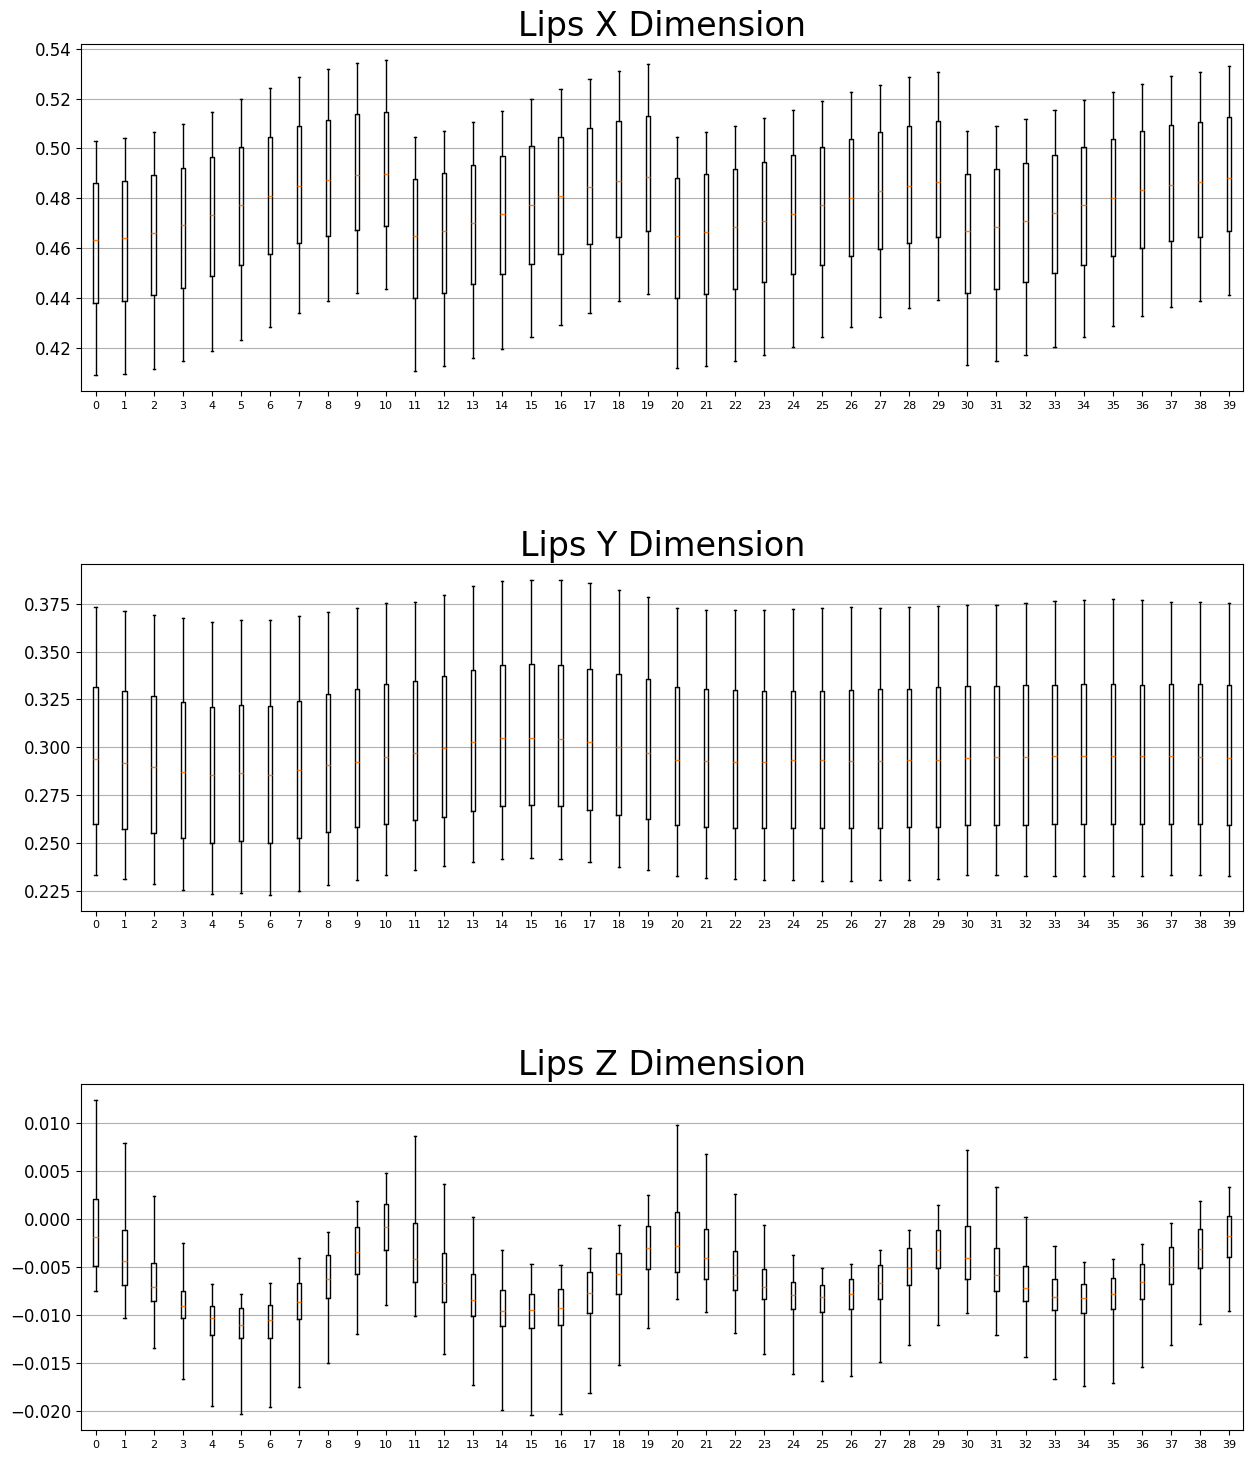

In [155]:
# LIPS
LIPS_MEAN_X = np.zeros([LIPS_IDXS.size], dtype=np.float32)
LIPS_MEAN_Y = np.zeros([LIPS_IDXS.size], dtype=np.float32)
LIPS_STD_X = np.zeros([LIPS_IDXS.size], dtype=np.float32)
LIPS_STD_Y = np.zeros([LIPS_IDXS.size], dtype=np.float32)

fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,LIPS_IDXS], [2,3,0,1]).reshape([LIPS_IDXS.size, N_DIMS, -1]) )):
    for dim, l in enumerate(ll):
        v = l[np.nonzero(l)]
        if dim == 0: # X
            LIPS_MEAN_X[col] = v.mean()
            LIPS_STD_X[col] = v.std()
        if dim == 1: # Y
            LIPS_MEAN_Y[col] = v.mean()
            LIPS_STD_Y[col] = v.std()

        axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

for ax, dim_name in zip(axes, DIM_NAMES):
    ax.set_title(f'Lips {dim_name.upper()} Dimension', size=24)
    ax.tick_params(axis='x', labelsize=8)
    ax.grid(axis='y')

plt.subplots_adjust(hspace=0.50)
plt.show()

LIPS_MEAN = np.array([LIPS_MEAN_X, LIPS_MEAN_Y]).T
LIPS_STD = np.array([LIPS_STD_X, LIPS_STD_Y]).T

  0%|          | 0/42 [00:00<?, ?it/s]

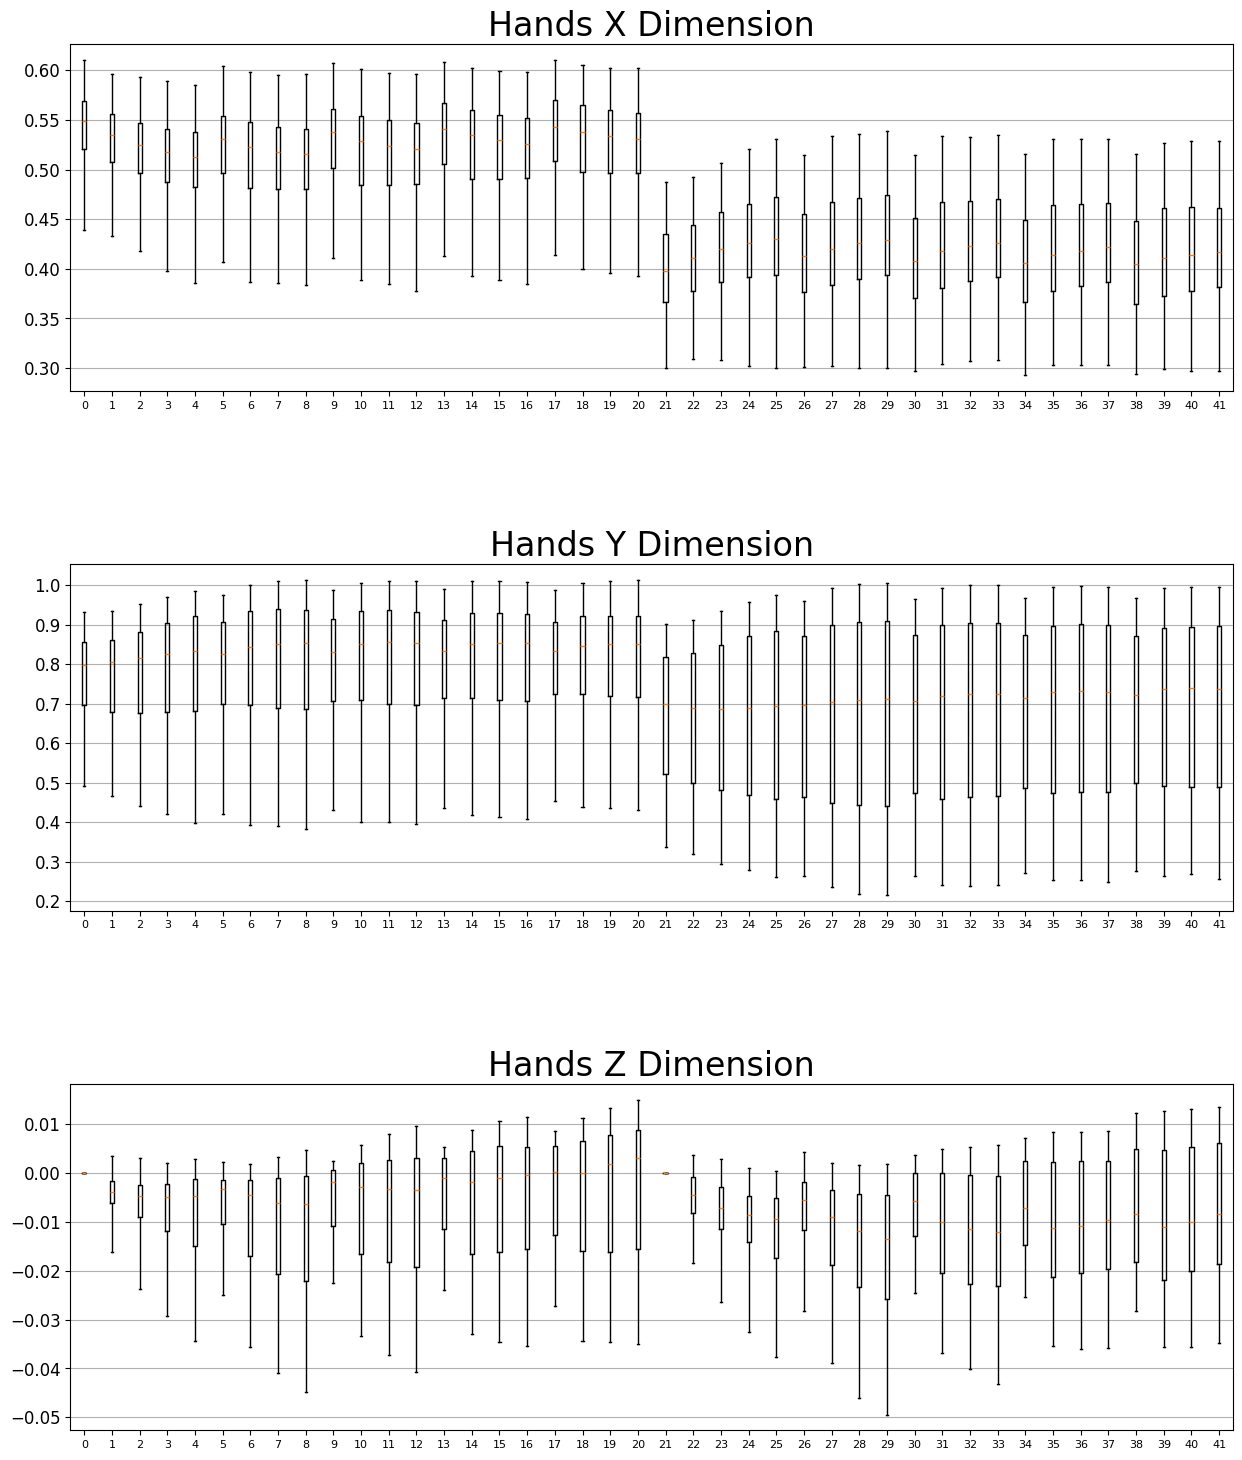

In [156]:
# LEFT HAND
LEFT_HANDS_MEAN_X = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
LEFT_HANDS_MEAN_Y = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
LEFT_HANDS_STD_X = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
LEFT_HANDS_STD_Y = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
# RIGHT HAND
RIGHT_HANDS_MEAN_X = np.zeros([RIGHT_HAND_IDXS.size], dtype=np.float32)
RIGHT_HANDS_MEAN_Y = np.zeros([RIGHT_HAND_IDXS.size], dtype=np.float32)
RIGHT_HANDS_STD_X = np.zeros([RIGHT_HAND_IDXS.size], dtype=np.float32)
RIGHT_HANDS_STD_Y = np.zeros([RIGHT_HAND_IDXS.size], dtype=np.float32)

fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,HAND_IDXS], [2,3,0,1]).reshape([HAND_IDXS.size, N_DIMS, -1]) )):
    for dim, l in enumerate(ll):
        v = l[np.nonzero(l)]
        if dim == 0: # X
            if col < RIGHT_HAND_IDXS.size: # LEFT HAND
                LEFT_HANDS_MEAN_X[col] = v.mean()
                LEFT_HANDS_STD_X[col] = v.std()
            else:
                RIGHT_HANDS_MEAN_X[col - LEFT_HAND_IDXS.size] = v.mean()
                RIGHT_HANDS_STD_X[col - LEFT_HAND_IDXS.size] = v.std()
        if dim == 1: # Y
            if col < RIGHT_HAND_IDXS.size: # LEFT HAND
                LEFT_HANDS_MEAN_Y[col] = v.mean()
                LEFT_HANDS_STD_Y[col] = v.std()
            else: # RIGHT HAND
                RIGHT_HANDS_MEAN_Y[col - LEFT_HAND_IDXS.size] = v.mean()
                RIGHT_HANDS_STD_Y[col - LEFT_HAND_IDXS.size] = v.std()

        axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

for ax, dim_name in zip(axes, DIM_NAMES):
    ax.set_title(f'Hands {dim_name.upper()} Dimension', size=24)
    ax.tick_params(axis='x', labelsize=8)
    ax.grid(axis='y')

plt.subplots_adjust(hspace=0.50)
plt.show()

LEFT_HANDS_MEAN = np.array([LEFT_HANDS_MEAN_X, LEFT_HANDS_MEAN_Y]).T
LEFT_HANDS_STD = np.array([LEFT_HANDS_STD_X, LEFT_HANDS_STD_Y]).T
RIGHT_HANDS_MEAN = np.array([RIGHT_HANDS_MEAN_X, RIGHT_HANDS_MEAN_Y]).T
RIGHT_HANDS_STD = np.array([RIGHT_HANDS_STD_X, RIGHT_HANDS_STD_Y]).T

  0%|          | 0/10 [00:00<?, ?it/s]

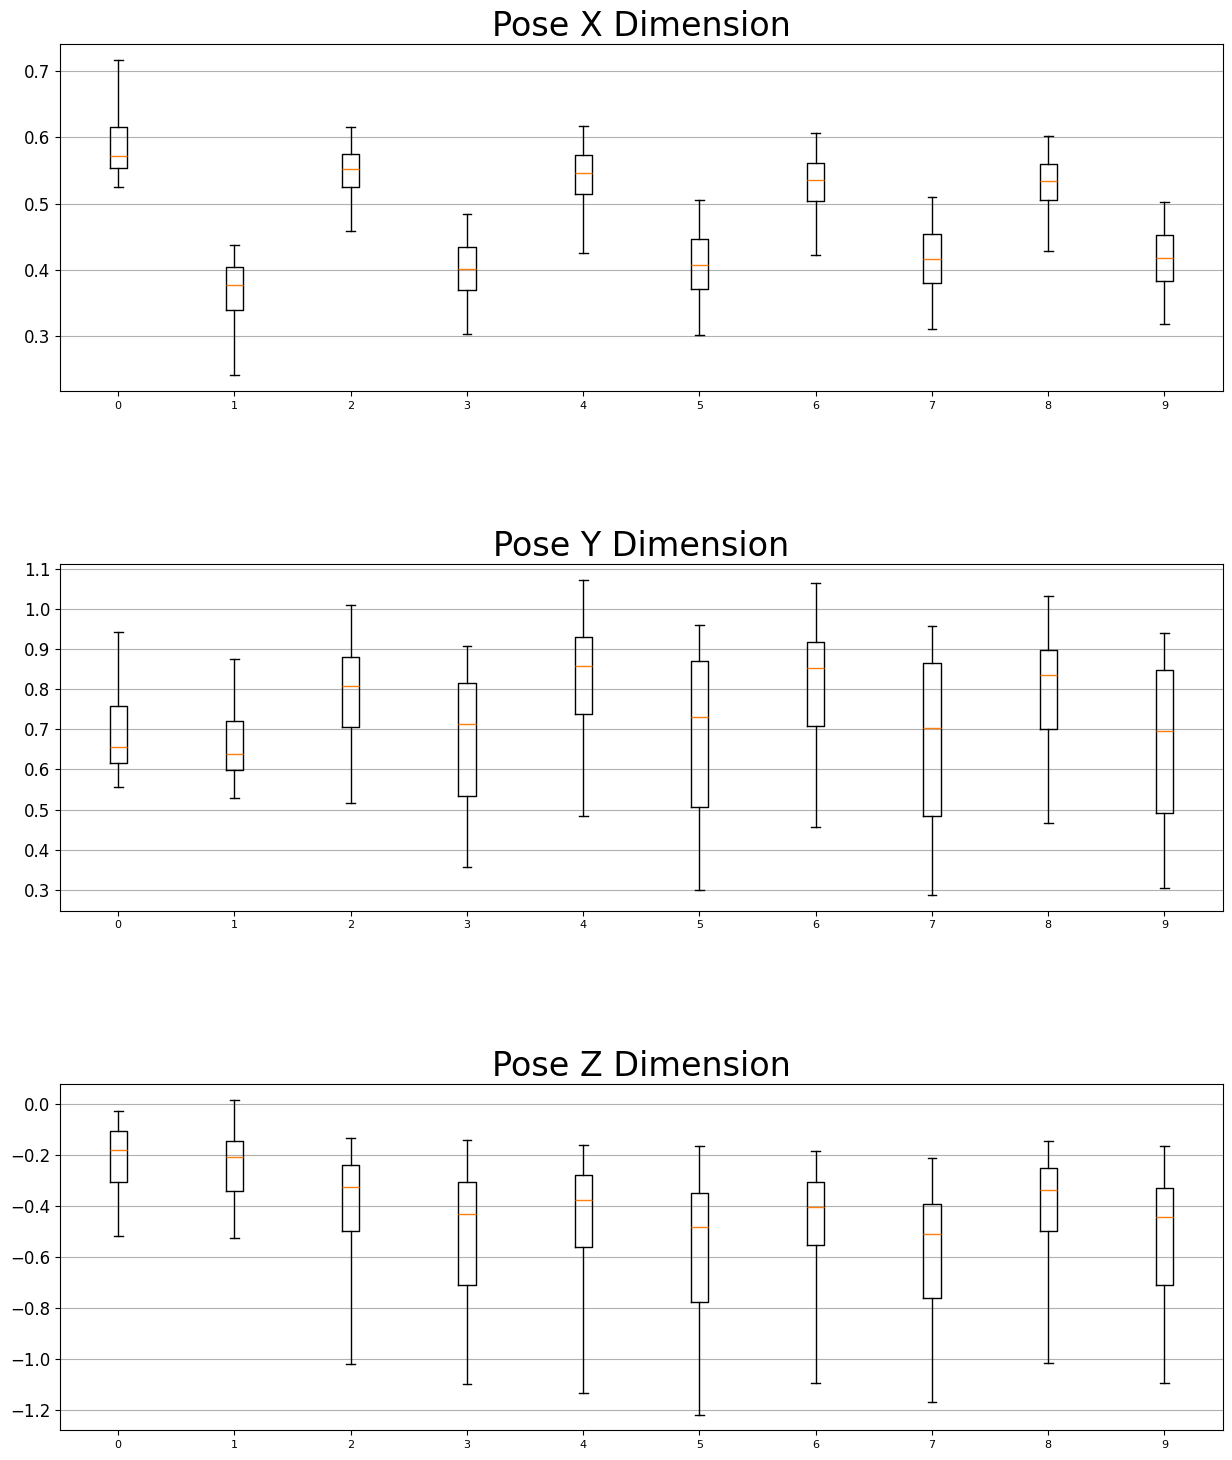

In [157]:
# POSE
POSE_MEAN_X = np.zeros([POSE_IDXS.size], dtype=np.float32)
POSE_MEAN_Y = np.zeros([POSE_IDXS.size], dtype=np.float32)
POSE_STD_X = np.zeros([POSE_IDXS.size], dtype=np.float32)
POSE_STD_Y = np.zeros([POSE_IDXS.size], dtype=np.float32)

fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,POSE_IDXS], [2,3,0,1]).reshape([POSE_IDXS.size, N_DIMS, -1]) )):
    for dim, l in enumerate(ll):
        v = l[np.nonzero(l)]
        if dim == 0: # X
            POSE_MEAN_X[col] = v.mean()
            POSE_STD_X[col] = v.std()
        if dim == 1: # Y
            POSE_MEAN_Y[col] = v.mean()
            POSE_STD_Y[col] = v.std()

        axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

for ax, dim_name in zip(axes, DIM_NAMES):
    ax.set_title(f'Pose {dim_name.upper()} Dimension', size=24)
    ax.tick_params(axis='x', labelsize=8)
    ax.grid(axis='y')

plt.subplots_adjust(hspace=0.50)
plt.show()

POSE_MEAN = np.array([POSE_MEAN_X, POSE_MEAN_Y]).T
POSE_STD = np.array([POSE_STD_X, POSE_STD_Y]).T

In [158]:
TIME_AUG_PROB = 0.25
FRAME_DROP_PROB = 0.0

# Custom sampler to get a batch containing N times all signs
def get_train_batch_all_signs(X, y, NON_EMPTY_FRAME_IDXS, n=BATCH_ALL_SIGNS_N):
    # Arrays to store batch in
    X_batch = np.zeros([NUM_CLASSES*n, INPUT_SIZE, N_COLS, N_DIMS], dtype=np.float32)
    y_batch = np.arange(0, NUM_CLASSES, step=1/n, dtype=np.float32).astype(np.int64)
    non_empty_frame_idxs_batch = np.zeros([NUM_CLASSES*n, INPUT_SIZE], dtype=np.float32)

    CLASS2IDXS = {}
    for i in range(NUM_CLASSES):
        CLASS2IDXS[i] = np.argwhere(y == i).squeeze().astype(np.int32)

    while True:
        # Fill batch arrays
        for i in range(NUM_CLASSES):
            idxs = np.random.choice(CLASS2IDXS[i], n)
            tmp = X[idxs].copy()
            tmp2 = NON_EMPTY_FRAME_IDXS[idxs].copy()

            # FRAME DROP AUGMENTATION
            if np.random.uniform(0,1)<FRAME_DROP_PROB:
                j = np.random.randint(0,INPUT_SIZE)
                tmp[0,j,:,:] = 0

            # TIME SCALE AUGMENTATION
            if np.random.uniform(0,1)<TIME_AUG_PROB:
                ct = ( NON_EMPTY_FRAME_IDXS[idxs[0]] != -1 ).sum()
                if (ct==12):
                    mask = np.random.choice([True, False],12)
                    mask[0] = True
                    mask[-1] = True
                    c = mask.sum()
                    tmp[0,:c,:,:] = tmp[0,mask,:,:]
                    tmp[0,c:,:,:] = 0
                    tmp2[0,:c] = tmp2[0,mask]
                    tmp2[0,c:] = -1
                elif ct>6:
                    tmp[0,:6,:,:] = tmp[0,::2,:,:]
                    tmp[0,6:,:,:] = 0
                    tmp2[0,:6] = tmp2[0,::2]
                    tmp2[0,6:] = -1
                elif (ct<=2)&(np.random.uniform(0,1)<0.3):
                    tmp[0,::6,:,:] = tmp[0,:2,:,:]
                    tmp[0,1::6,:,:] = tmp[0,:2,:,:]
                    tmp[0,2::6,:,:] = tmp[0,:2,:,:]
                    tmp[0,3::6,:,:] = tmp[0,:2,:,:]
                    tmp[0,4::6,:,:] = tmp[0,:2,:,:]
                    tmp[0,5::6,:,:] = tmp[0,:2,:,:]
                    tmp2[0,::6] = tmp2[0,:2]
                    tmp2[0,1::6] = tmp2[0,:2]
                    tmp2[0,2::6] = tmp2[0,:2]
                    tmp2[0,3::6] = tmp2[0,:2]
                    tmp2[0,4::6] = tmp2[0,:2]
                    tmp2[0,5::6] = tmp2[0,:2]
                elif (ct<=3)&(np.random.uniform(0,1)<0.3):
                    tmp[0,::4,:,:] = tmp[0,:3,:,:]
                    tmp[0,1::4,:,:] = tmp[0,:3,:,:]
                    tmp[0,2::4,:,:] = tmp[0,:3,:,:]
                    tmp[0,3::4,:,:] = tmp[0,:3,:,:]
                    tmp2[0,::4] = tmp2[0,:3]
                    tmp2[0,1::4] = tmp2[0,:3]
                    tmp2[0,2::4] = tmp2[0,:3]
                    tmp2[0,3::4] = tmp2[0,:3]
                elif (ct<=4)&(np.random.uniform(0,1)<0.3):
                    tmp[0,::3,:,:] = tmp[0,:4,:,:]
                    tmp[0,1::3,:,:] = tmp[0,:4,:,:]
                    tmp[0,2::3,:,:] = tmp[0,:4,:,:]
                    tmp2[0,::3] = tmp2[0,:4]
                    tmp2[0,1::3] = tmp2[0,:4]
                    tmp2[0,2::3] = tmp2[0,:4]
                else:
                    tmp[0,::2,:,:] = tmp[0,:6,:,:]
                    tmp[0,1::2,:,:] = tmp[0,:6,:,:]
                    tmp2[0,::2] = tmp2[0,:6]
                    tmp2[0,1::2] = tmp2[0,:6]

            X_batch[i*n:(i+1)*n] = tmp
            non_empty_frame_idxs_batch[i*n:(i+1)*n] = tmp2

        yield { 'frames': X_batch, 'non_empty_frame_idxs': non_empty_frame_idxs_batch }, y_batch

In [159]:
# Epsilon value for layer normalisation
LAYER_NORM_EPS = 1e-6

# Dense layer units for landmarks
LIPS_UNITS = 384
HANDS_UNITS = 384
POSE_UNITS = 384
# final embedding and transformer embedding size
UNITS = 512

# Transformer
NUM_BLOCKS =3
MLP_RATIO = 3

# Dropout
EMBEDDING_DROPOUT = 0.00
MLP_DROPOUT_RATIO = 0.30
CLASSIFIER_DROPOUT_RATIO = 0.10

# Initializers
INIT_HE_UNIFORM = tf.keras.initializers.he_uniform
INIT_GLOROT_UNIFORM = tf.keras.initializers.glorot_uniform
INIT_ZEROS = tf.keras.initializers.constant(0.0)
# Activations
GELU = tf.keras.activations.gelu

In [160]:
def scaled_dot_product(q,k,v, softmax, attention_mask):
    #calculates Q . K(transpose)
    qkt = tf.matmul(q,k,transpose_b=True)
    #caculates scaling factor
    dk = tf.math.sqrt(tf.cast(q.shape[-1],dtype=tf.float32))
    scaled_qkt = qkt/dk
    softmax = softmax(scaled_qkt, mask=attention_mask)

    z = tf.matmul(softmax,v)
    #shape: (m,Tx,depth)
    return z

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self,d_model,num_of_heads):
        super(MultiHeadAttention,self).__init__()
        self.d_model = d_model
        self.num_of_heads = num_of_heads
        self.depth = d_model//num_of_heads
        self.wq = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wk = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wv = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wo = tf.keras.layers.Dense(d_model)
        self.softmax = tf.keras.layers.Softmax()

    def call(self,x, attention_mask):

        multi_attn = []
        for i in range(self.num_of_heads):
            Q = self.wq[i](x)
            K = self.wk[i](x)
            V = self.wv[i](x)
            multi_attn.append(scaled_dot_product(Q,K,V, self.softmax, attention_mask))

        multi_head = tf.concat(multi_attn,axis=-1)
        multi_head_attention = self.wo(multi_head)
        return multi_head_attention

In [161]:
# Full Transformer
class Transformer(tf.keras.Model):
    def __init__(self, num_blocks):
        super(Transformer, self).__init__(name='transformer')
        self.num_blocks = num_blocks

    def build(self, input_shape):
        self.ln_1s = []
        self.mhas = []
        self.ln_2s = []
        self.mlps = []
        # Make Transformer Blocks
        for i in range(self.num_blocks):
            # First Layer Normalisation
            self.ln_1s.append(tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS))
            # Multi Head Attention
            self.mhas.append(MultiHeadAttention(UNITS, 4))
            # Second Layer Normalisation
            self.ln_2s.append(tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS))
            # Multi Layer Perception
            self.mlps.append(tf.keras.Sequential([
                tf.keras.layers.Dense(UNITS * MLP_RATIO, activation=GELU, kernel_initializer=INIT_GLOROT_UNIFORM),
                tf.keras.layers.Dropout(MLP_DROPOUT_RATIO),
                tf.keras.layers.Dense(UNITS, kernel_initializer=INIT_HE_UNIFORM),
            ]))

    def call(self, x, attention_mask):
        # Iterate input over transformer blocks
        for ln_1, mha, ln_2, mlp in zip(self.ln_1s, self.mhas, self.ln_2s, self.mlps):
            x1 = ln_1(x)
            attention_output = mha(x1, attention_mask)
            x2 = x1 + attention_output
            x3 = ln_2(x2)
            x3 = mlp(x3)
            x = x3 + x2

        return x

In [162]:
class LandmarkEmbedding(tf.keras.Model):
    def __init__(self, units, name):
        super(LandmarkEmbedding, self).__init__(name=f'{name}_embedding')
        self.units = units

    def build(self, input_shape):
        # Embedding for missing landmark in frame, initizlied with zeros
        self.empty_embedding = self.add_weight(
            name=f'{self.name}_empty_embedding',
            shape=[self.units],
            initializer=INIT_ZEROS,
        )
        # Embedding
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM, activation=GELU),
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name=f'{self.name}_dense')

    def call(self, x):
        return tf.where(
                # Checks whether landmark is missing in frame
                tf.reduce_sum(x, axis=2, keepdims=True) == 0,
                # If so, the empty embedding is used
                self.empty_embedding,
                # Otherwise the landmark data is embedded
                self.dense(x),
            )

In [163]:
class Embedding(tf.keras.Model):
    def __init__(self):
        super(Embedding, self).__init__()

    def get_diffs(self, l):
        S = l.shape[2]
        other = tf.expand_dims(l, 3)
        other = tf.repeat(other, S, axis=3)
        other = tf.transpose(other, [0,1,3,2])
        diffs = tf.expand_dims(l, 3) - other
        diffs = tf.reshape(diffs, [-1, INPUT_SIZE, S*S])
        return diffs

    def build(self, input_shape):
        # Positional Embedding, initialized with zeros
        self.positional_embedding = tf.keras.layers.Embedding(INPUT_SIZE+1, UNITS, embeddings_initializer=INIT_ZEROS)
        # Embedding layer for Landmarks
        self.lips_embedding = LandmarkEmbedding(LIPS_UNITS, 'lips')
        self.left_hand_embedding = LandmarkEmbedding(HANDS_UNITS, 'left_hand')
        self.right_hand_embedding = LandmarkEmbedding(HANDS_UNITS, 'right_hand')
        self.pose_embedding = LandmarkEmbedding(POSE_UNITS, 'pose')
        # Landmark Weights
        initial_weights = tf.constant([0.1, 0.4, 0.4, 0.1])  # we hardcode weights of lips, left hand, right hand, pose (hands more weight)
        self.landmark_weights = tf.Variable(initial_weights, dtype=tf.float32, name='landmark_weights')
        # Fully Connected Layers for combined landmarks
        self.fc = tf.keras.Sequential([
            tf.keras.layers.Dense(UNITS, name='fully_connected_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM, activation=GELU),
            tf.keras.layers.Dense(UNITS, name='fully_connected_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name='fc')


    def call(self, lips0, left_hand0, right_hand0, pose0, non_empty_frame_idxs, training=False):
        # Lips
        lips_embedding = self.lips_embedding(lips0)
        # Left Hand
        left_hand_embedding = self.left_hand_embedding(left_hand0)
        # Right Hand
        right_hand_embedding = self.right_hand_embedding(right_hand0)
        # Pose
        pose_embedding = self.pose_embedding(pose0)
        # Merge Embeddings of all landmarks with mean pooling
        x = tf.stack((lips_embedding, left_hand_embedding, right_hand_embedding, pose_embedding), axis=3)
        # Merge Landmarks with trainable attention weights
        x = x * tf.nn.softmax(self.landmark_weights)
        x = tf.reduce_sum(x, axis=3)
        # Fully Connected Layers
        x = self.fc(x)
        # Add Positional Embedding
        normalised_non_empty_frame_idxs = tf.where(
            tf.math.equal(non_empty_frame_idxs, -1.0),
            INPUT_SIZE,
            tf.cast(
                non_empty_frame_idxs / tf.reduce_max(non_empty_frame_idxs, axis=1, keepdims=True) * INPUT_SIZE,
                tf.int32,
            ),
        )
        x = x + self.positional_embedding(normalised_non_empty_frame_idxs)

        return x

In [164]:
def get_model():
    # Inputs
    frames = tf.keras.layers.Input([INPUT_SIZE, N_COLS, N_DIMS], dtype=tf.float32, name='frames')
    non_empty_frame_idxs = tf.keras.layers.Input([INPUT_SIZE], dtype=tf.float32, name='non_empty_frame_idxs')
    # Padding Mask
    mask = tf.cast(tf.math.not_equal(non_empty_frame_idxs, -1), tf.float32)
    mask = tf.expand_dims(mask, axis=2)

    """
        left_hand: 468:489
        pose: 489:522
        right_hand: 522:543
    """
    x = frames
    x = tf.slice(x, [0,0,0,0], [-1,INPUT_SIZE, N_COLS, 2])
    # LIPS
    lips = tf.slice(x, [0,0,LIPS_START,0], [-1,INPUT_SIZE, 40, 2])
    lips = tf.where(
            tf.math.equal(lips, 0.0),
            0.0,
            (lips - LIPS_MEAN) / LIPS_STD,
        )
    lips = tf.reshape(lips, [-1, INPUT_SIZE, 40*2])
    # LEFT HAND
    left_hand = tf.slice(x, [0,0,40,0], [-1,INPUT_SIZE, 21, 2])
    left_hand = tf.where(
            tf.math.equal(left_hand, 0.0),
            0.0,
            (left_hand - LEFT_HANDS_MEAN) / LEFT_HANDS_STD,
        )
    left_hand = tf.reshape(left_hand, [-1, INPUT_SIZE, 21*2])
    # RIGHT HAND
    right_hand = tf.slice(x, [0,0,61,0], [-1,INPUT_SIZE, 21, 2])
    right_hand = tf.where(
            tf.math.equal(right_hand, 0.0),
            0.0,
            (right_hand - RIGHT_HANDS_MEAN) / RIGHT_HANDS_STD,
        )
    right_hand = tf.reshape(right_hand, [-1, INPUT_SIZE, 21*2])
    # POSE
    pose = tf.slice(x, [0,0,82,0], [-1,INPUT_SIZE, 10, 2])
    pose = tf.where(
            tf.math.equal(pose, 0.0),
            0.0,
            (pose - POSE_MEAN) / POSE_STD,
        )
    pose = tf.reshape(pose, [-1, INPUT_SIZE, 10*2])

    x = lips, left_hand, right_hand, pose

    x = Embedding()(lips, left_hand, right_hand, pose, non_empty_frame_idxs)

    # Encoder Transformer Blocks
    x = Transformer(NUM_BLOCKS)(x, mask)

    # Pooling
    x = tf.reduce_sum(x * mask, axis=1) / tf.reduce_sum(mask, axis=1)
    # Classifier Dropout
    x = tf.keras.layers.Dropout(CLASSIFIER_DROPOUT_RATIO)(x)
    # Classification Layer
    x = tf.keras.layers.Dense(NUM_CLASSES, activation=tf.keras.activations.softmax, kernel_initializer=INIT_GLOROT_UNIFORM)(x)

    outputs = x

    # Create Tensorflow Model
    model = tf.keras.models.Model(inputs=[frames, non_empty_frame_idxs], outputs=outputs)

    # Simple Categorical Crossentropy Loss
    loss = tf.keras.losses.SparseCategoricalCrossentropy()

    # Adam Optimizer with weight decay
    optimizer = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5, clipnorm=1.0)

    # TopK Metrics
    metrics = [
        tf.keras.metrics.SparseCategoricalAccuracy(name='acc'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_5_acc'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name='top_10_acc'),
    ]

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    return model

In [165]:
tf.keras.backend.clear_session()

model = get_model()

In [166]:
# Plot model summary
model.summary(expand_nested=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 frames (InputLayer)         [(None, 12, 92, 3)]          0         []                            
                                                                                                  
 tf.slice (TFOpLambda)       (None, 12, 92, 2)            0         ['frames[0][0]']              
                                                                                                  
 tf.slice_1 (TFOpLambda)     (None, 12, 40, 2)            0         ['tf.slice[0][0]']            
                                                                                                  
 tf.slice_2 (TFOpLambda)     (None, 12, 21, 2)            0         ['tf.slice[0][0]']            
                                                                                              

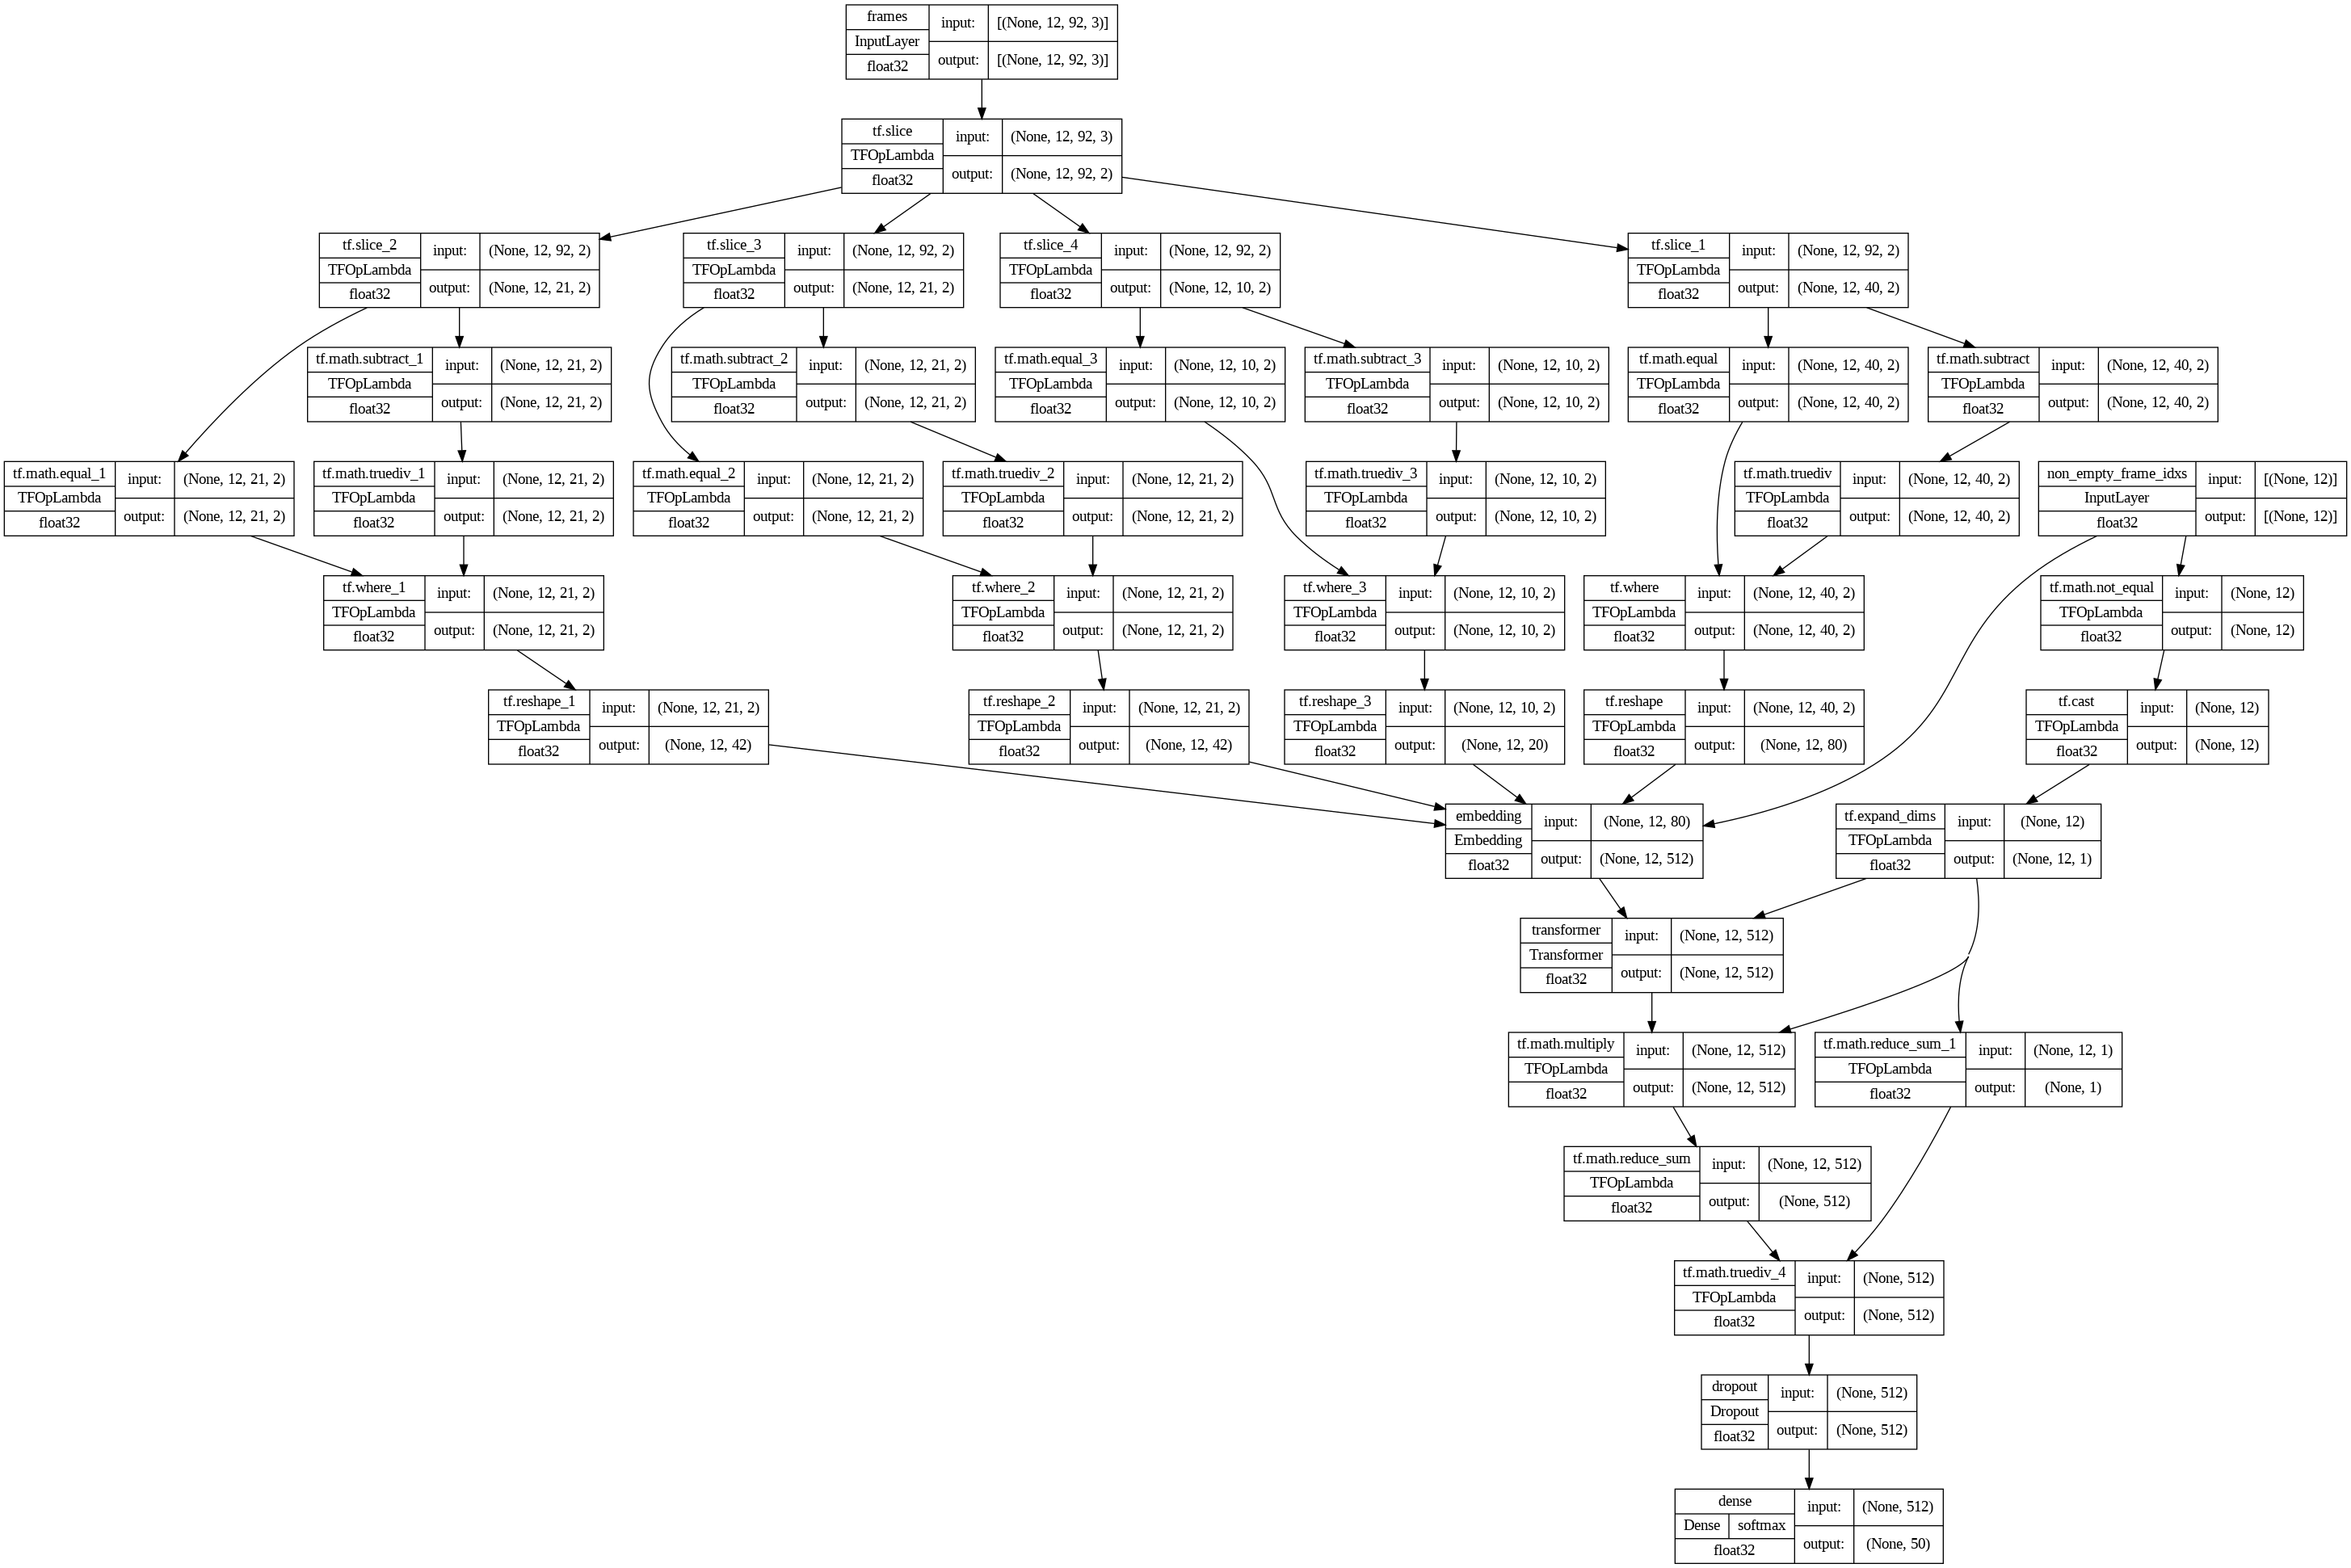

In [167]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, expand_nested=True, show_layer_activations=True)

In [168]:
def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=N_EPOCHS):

    if current_step < num_warmup_steps:
        if WARMUP_METHOD == 'log':
            return lr_max * 0.10 ** (num_warmup_steps - current_step)
        else:
            return lr_max * 2 ** -(num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max


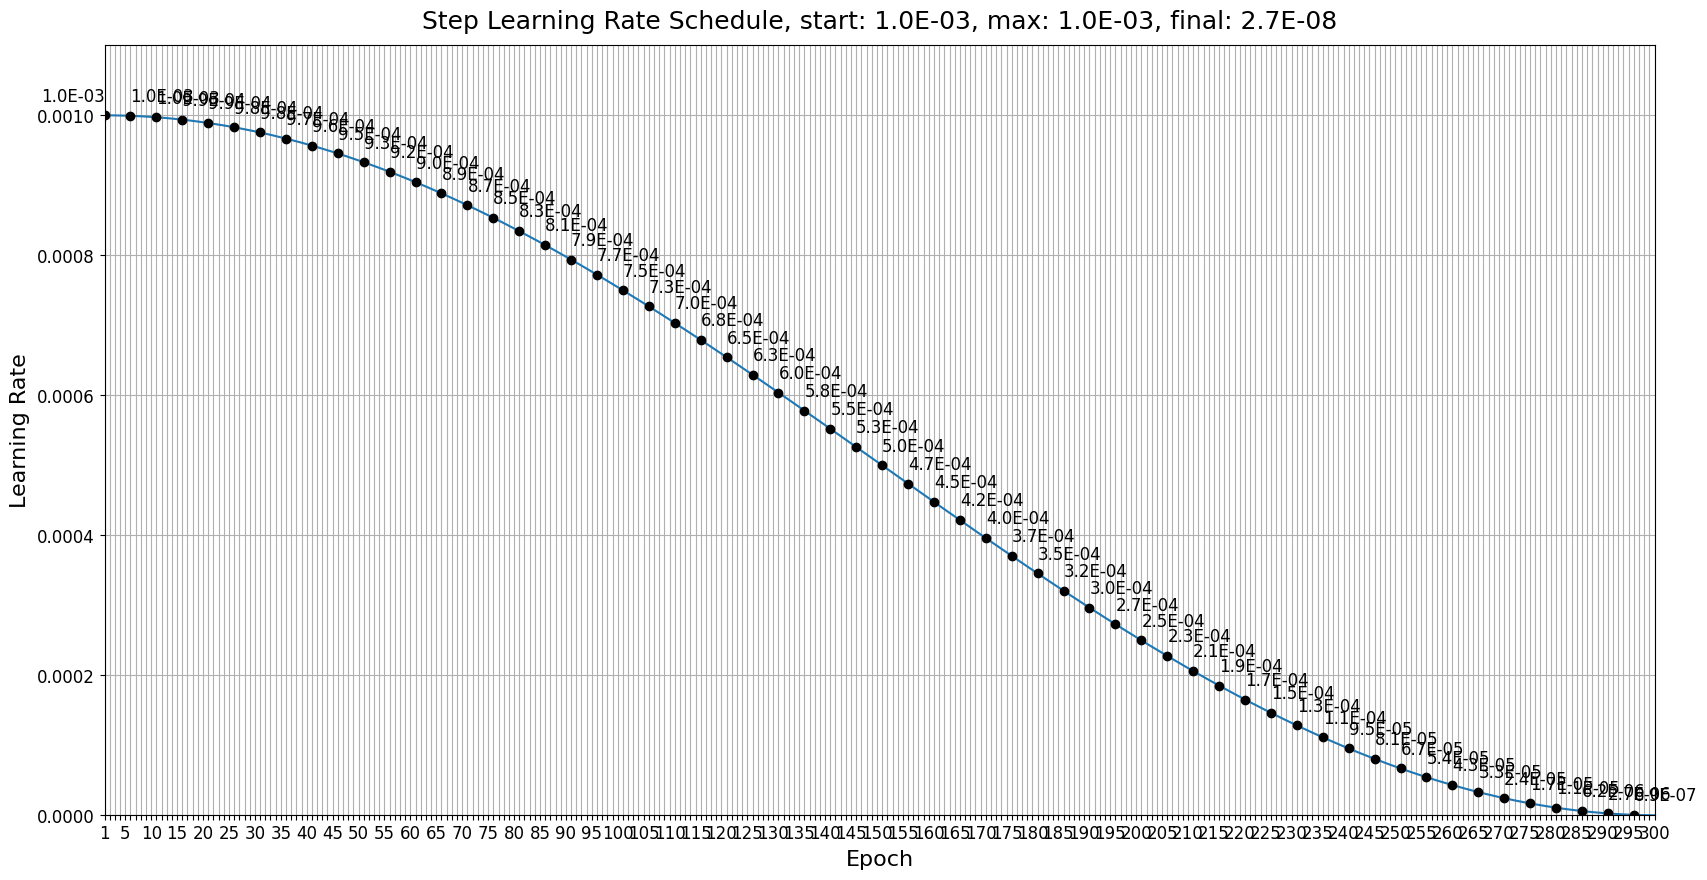

In [169]:
def plot_lr_schedule(lr_schedule, epochs):
    fig = plt.figure(figsize=(20, 10))
    plt.plot([None] + lr_schedule + [None])
    # X Labels
    x = np.arange(1, epochs + 1)
    x_axis_labels = [i if epochs <= 40 or i % 5 == 0 or i == 1 else None for i in range(1, epochs + 1)]
    plt.xlim([1, epochs])
    plt.xticks(x, x_axis_labels)

    # Increase y-limit for better readability
    plt.ylim([0, max(lr_schedule) * 1.1])

    # Title
    schedule_info = f'start: {lr_schedule[0]:.1E}, max: {max(lr_schedule):.1E}, final: {lr_schedule[-1]:.1E}'
    plt.title(f'Step Learning Rate Schedule, {schedule_info}', size=18, pad=12)

    # Plot Learning Rates
    for x, val in enumerate(lr_schedule):
        if epochs <= 40 or x % 5 == 0 or x is epochs - 1:
            if x < len(lr_schedule) - 1:
                if lr_schedule[x - 1] < val:
                    ha = 'right'
                else:
                    ha = 'left'
            elif x == 0:
                ha = 'right'
            else:
                ha = 'left'
            plt.plot(x + 1, val, 'o', color='black');
            offset_y = (max(lr_schedule) - min(lr_schedule)) * 0.02
            plt.annotate(f'{val:.1E}', xy=(x + 1, val + offset_y), size=12, ha=ha)

    plt.xlabel('Epoch', size=16, labelpad=5)
    plt.ylabel('Learning Rate', size=16, labelpad=5)
    plt.grid()
    plt.show()

# Learning rate for encoder
LR_SCHEDULE = [lrfn(step, num_warmup_steps=N_WARMUP_EPOCHS, lr_max=LR_MAX, num_cycles=0.50) for step in range(N_EPOCHS)]
# Plot Learning Rate Schedule
plot_lr_schedule(LR_SCHEDULE, epochs=N_EPOCHS)
# Learning Rate Callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=1)

In [170]:
class WeightDecayCallback(tf.keras.callbacks.Callback):
    def __init__(self, wd_ratio=WD_RATIO):
        self.step_counter = 0
        self.wd_ratio = wd_ratio

    def on_epoch_begin(self, epoch, logs=None):
        model.optimizer.weight_decay = model.optimizer.learning_rate * self.wd_ratio
        print(f'learning rate: {model.optimizer.learning_rate.numpy():.2e}, weight decay: {model.optimizer.weight_decay.numpy():.2e}')

# Train

In [171]:
if TRAIN_MODEL:
    models = []

    for k in range(N_MODELS):
        print('#'*25)
        print('### Training Model',k,'...')
        print('#'*25)

        # Clear all models in GPU
        VERBOSE = 0; VERBOSE2 = 0
        if k==0:
            tf.keras.backend.clear_session()
            VERBOSE = 2; VERBOSE2 = 1

        # Get new fresh model
        model = get_model()

        # Sanity Check
        #model.summary()

        # Actual Training
        lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step],
                                                               verbose=VERBOSE2)
        history = model.fit(
                x=get_train_batch_all_signs(X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN),
                steps_per_epoch=len(X_train) // (NUM_CLASSES * BATCH_ALL_SIGNS_N),
                epochs=N_EPOCHS,
                batch_size=BATCH_SIZE,
                validation_data=validation_data,
                callbacks=[
                    lr_callback,
                    WeightDecayCallback(),
                ],
                verbose = VERBOSE,
            )

        # Save Model Weights
        model.save_weights(f'model{k}.h5')
        models.append(model)

#########################
### Training Model 0 ...
#########################

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
learning rate: 1.00e-03, weight decay: 5.00e-05
Epoch 1/300
3/3 - 19s - loss: 7.1405 - acc: 0.1067 - top_5_acc: 0.2867 - top_10_acc: 0.3800 - lr: 0.0010 - 19s/epoch - 6s/step

Epoch 2: LearningRateScheduler setting learning rate to 0.000999972584682756.
learning rate: 1.00e-03, weight decay: 5.00e-05
Epoch 2/300
3/3 - 2s - loss: 7.3828 - acc: 0.1933 - top_5_acc: 0.3933 - top_10_acc: 0.5667 - lr: 9.9997e-04 - 2s/epoch - 707ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0009998903417374227.
learning rate: 1.00e-03, weight decay: 5.00e-05
Epoch 3/300
3/3 - 3s - loss: 6.1505 - acc: 0.2067 - top_5_acc: 0.4867 - top_10_acc: 0.6667 - lr: 9.9989e-04 - 3s/epoch - 932ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0009997532801828658.
learning rate: 1.00e-03, weight decay: 5.00e-05
Epoch 4/300
3/3 - 4s - loss: 4.5293 -

In [172]:
def plot_history_metric(metric, f_best=np.argmax, ylim=None, yscale=None, yticks=None):
    plt.figure(figsize=(20, 10))

    values = history.history[metric]
    N_EPOCHS = len(values)
    val = 'val' in ''.join(history.history.keys())
    # Epoch Ticks
    if N_EPOCHS <= 20:
        x = np.arange(1, N_EPOCHS + 1)
    else:
        x = [1, 5] + [10 + 5 * idx for idx in range((N_EPOCHS - 10) // 5 + 1)]

    x_ticks = np.arange(1, N_EPOCHS+1)

    # Validation
    if val:
        val_values = history.history[f'val_{metric}']
        val_argmin = f_best(val_values)
        plt.plot(x_ticks, val_values, label=f'val')

    # summarize history for accuracy
    plt.plot(x_ticks, values, label=f'train')
    argmin = f_best(values)
    plt.scatter(argmin + 1, values[argmin], color='red', s=75, marker='o', label=f'train_best')
    if val:
        plt.scatter(val_argmin + 1, val_values[val_argmin], color='purple', s=75, marker='o', label=f'val_best')

    plt.title(f'Model {metric}', fontsize=24, pad=10)
    plt.ylabel(metric, fontsize=20, labelpad=10)

    if ylim:
        plt.ylim(ylim)

    if yscale is not None:
        plt.yscale(yscale)

    if yticks is not None:
        plt.yticks(yticks, fontsize=16)

    plt.xlabel('epoch', fontsize=20, labelpad=10)
    plt.tick_params(axis='x', labelsize=8)
    plt.xticks(x, fontsize=16) # set tick step to 1 and let x axis start at 1
    plt.yticks(fontsize=16)

    plt.legend(prop={'size': 10})
    plt.grid()
    plt.show()

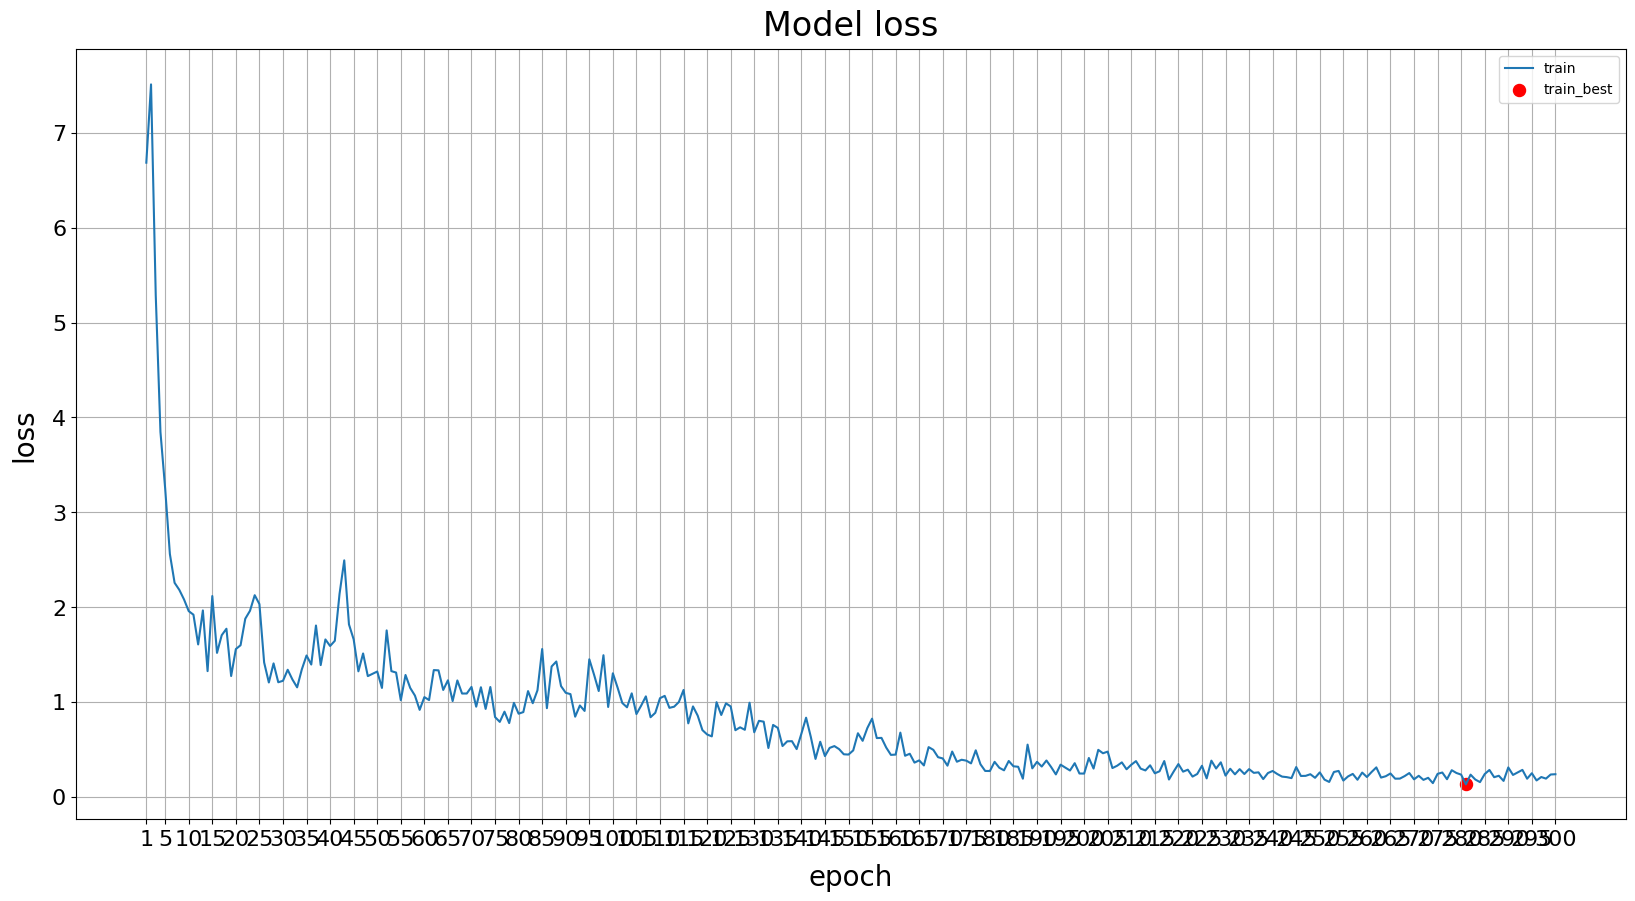

In [173]:
if TRAIN_MODEL:
    plot_history_metric('loss', f_best=np.argmin)

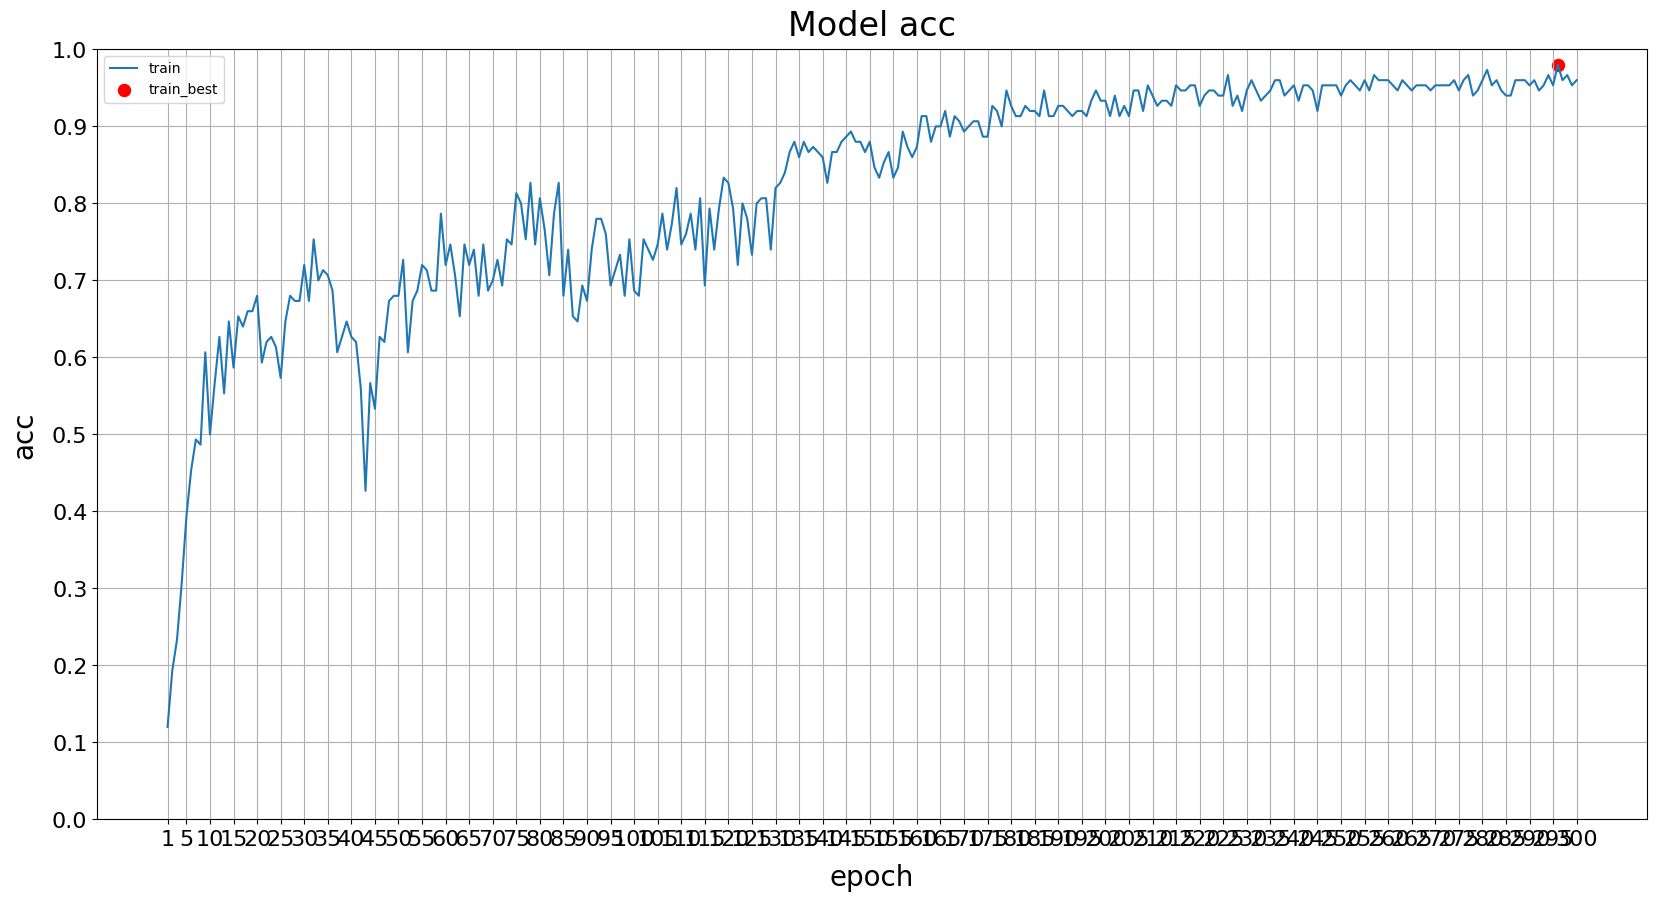

In [174]:
if TRAIN_MODEL:
    plot_history_metric('acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

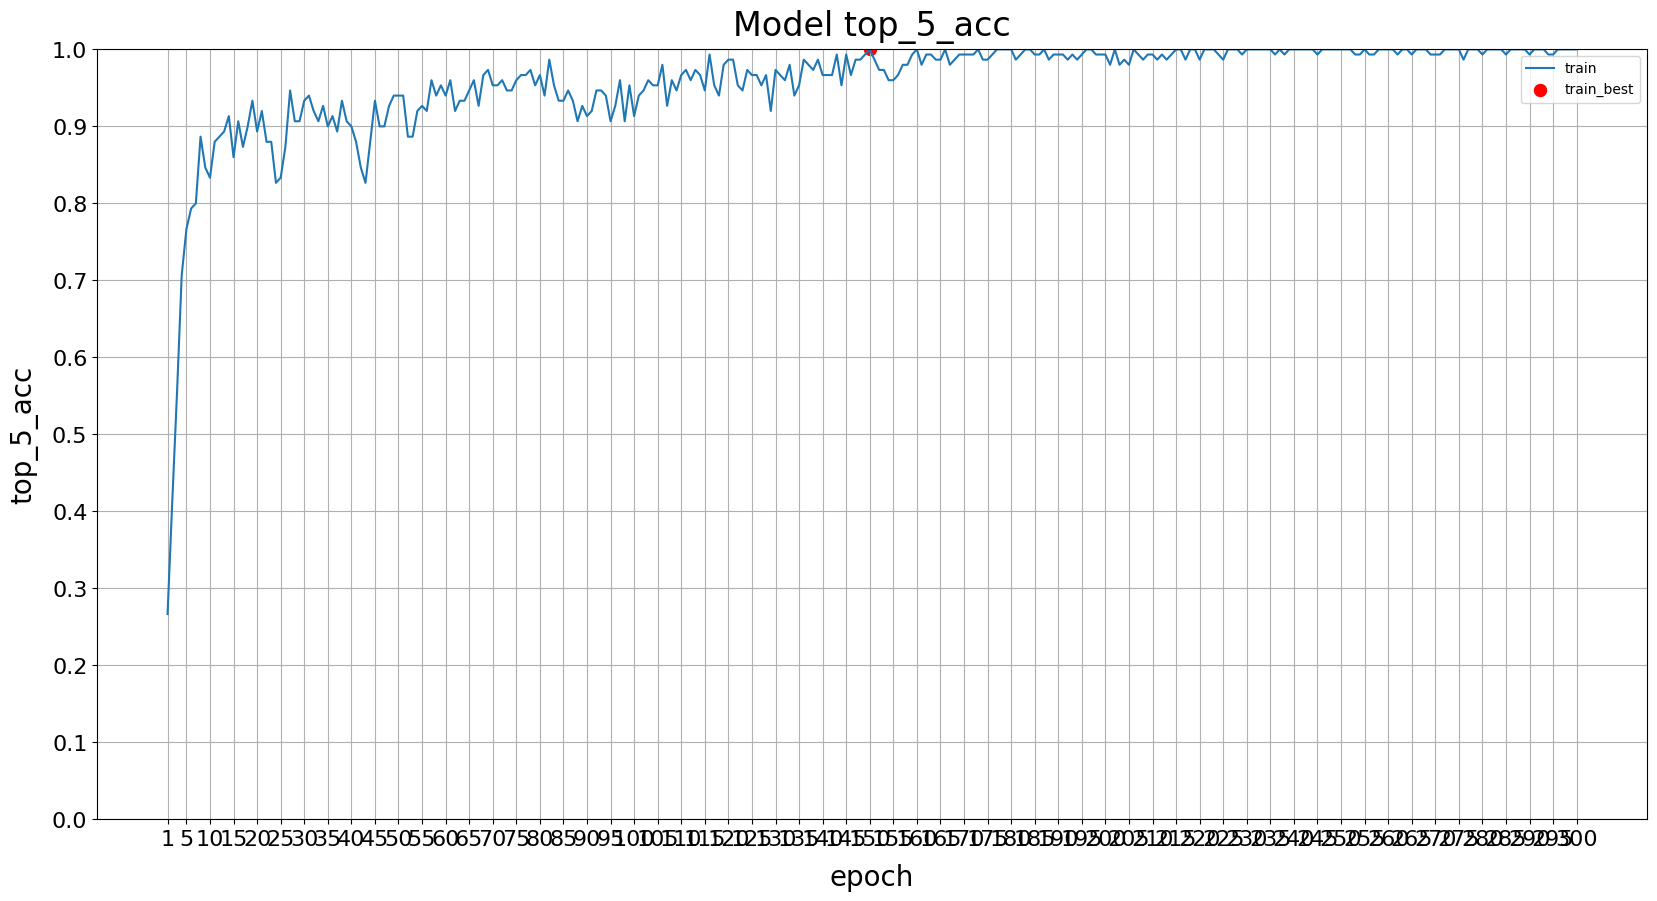

In [175]:
if TRAIN_MODEL:
    plot_history_metric('top_5_acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

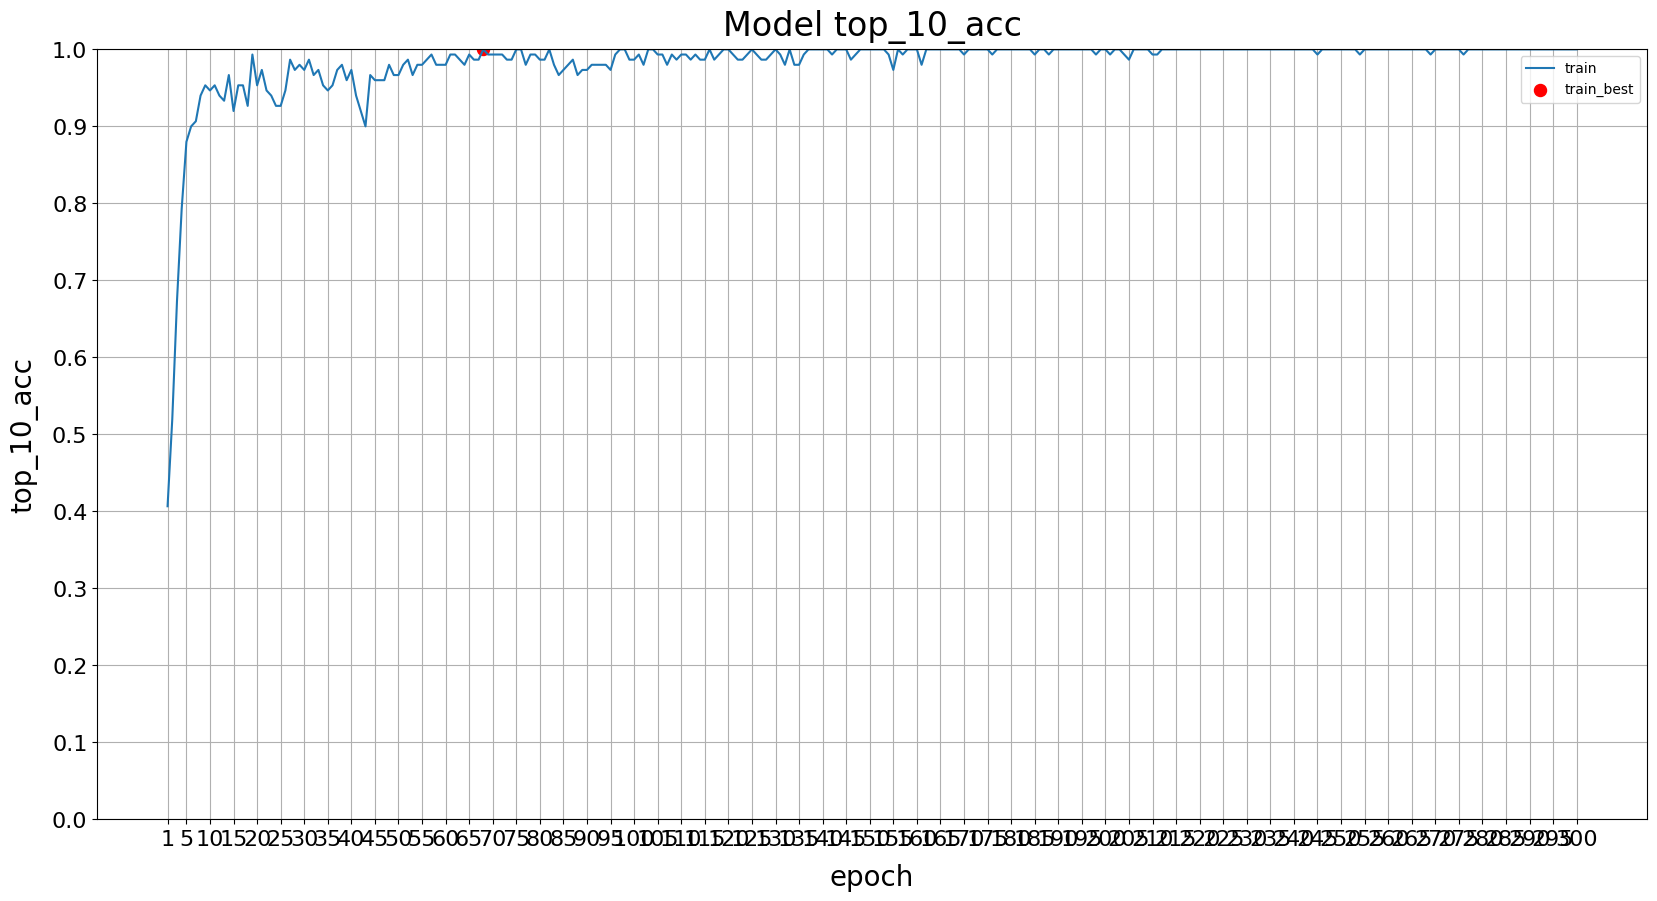

In [176]:
if TRAIN_MODEL:
    plot_history_metric('top_10_acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

# Submission

Submission code loosley based on [this notebook](https://www.kaggle.com/code/dschettler8845/gislr-learn-eda-baseline#baseline) by [Darien Schettler
](https://www.kaggle.com/dschettler8845)

In [177]:
# TFLite model for submission
class TFLiteModel(tf.Module):
    def __init__(self, models):
        super(TFLiteModel, self).__init__()

        # Load the feature generation and main models
        self.preprocess_layer = preprocess_layer
        self.models = models

    @tf.function(input_signature=[tf.TensorSpec(shape=[None, N_ROWS, N_DIMS], dtype=tf.float32, name='inputs')])
    def __call__(self, inputs):
        # Preprocess Data
        x, non_empty_frame_idxs = self.preprocess_layer(inputs)
        # Add Batch Dimension
        x = tf.expand_dims(x, axis=0)
        non_empty_frame_idxs = tf.expand_dims(non_empty_frame_idxs, axis=0)

        # Make Prediction
        outputs = []
        for k in range(len(self.models)):
            output = self.models[k]({ 'frames': x, 'non_empty_frame_idxs': non_empty_frame_idxs })
            # Squeeze Output 1x250 -> 250
            output = tf.squeeze(output, axis=0)
            outputs.append(output)
        outputs = tf.math.reduce_mean( outputs, axis=0 )

        return {'outputs': outputs}

# Define TF Lite Model
tflite_keras_model = TFLiteModel(models)

# Sanity Check
demo_raw_data = load_relevant_data_subset(train['file_path'].values[5])
print(f'demo_raw_data shape: {demo_raw_data.shape}, dtype: {demo_raw_data.dtype}')
demo_output = tflite_keras_model(demo_raw_data)["outputs"]
print(f'demo_output shape: {demo_output.shape}, dtype: {demo_output.dtype}')
demo_prediction = demo_output.numpy().argmax()
print(f'demo_prediction: {demo_prediction}, correct: {train.iloc[0]["sign_ord"]}')

demo_raw_data shape: (54, 543, 3), dtype: float32
demo_output shape: (50,), dtype: <dtype: 'float32'>
demo_prediction: 43, correct: 38


In [181]:
# Create Model Converter
keras_model_converter = tf.lite.TFLiteConverter.from_keras_model(tflite_keras_model)

# QUANTIZE
QUANTIZE = 'fp16'
if QUANTIZE in ["int8", "fp16"]:
    keras_model_converter.optimizations = [tf.lite.Optimize.DEFAULT]
    if QUANTIZE == "fp16":
        keras_model_converter.target_spec.supported_types = [tf.float16]

# Convert Model
tflite_model = keras_model_converter.convert()
# Write Model
with open('/content/drive/MyDrive/SIGN/Documentos/model.tflite', 'wb') as f:
    f.write(tflite_model)

# Prediction test

In [1]:
!pip install tensorflow==2.13.0
!pip install tensorflow_addons
!pip install keras

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sn

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, GroupShuffleSplit

import glob
import sys
import os
import math
import gc
import sys
import sklearn
import scipy

/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
videos = pd.read_csv('/content/drive/MyDrive/SIGN/Documentos/video_details.csv') # notice if this is correctly set

train = videos[videos['Type']=='train']
train.drop('Unnamed: 0', axis=1, inplace=True)

# assign number to each sign name
train['sign_ord'] = train['Label'].astype('category').cat.codes

# Dictionaries to translate sign <-> ordinal encoded sign
SIGN2ORD = train[['Label', 'sign_ord']].set_index('Label').squeeze().to_dict()
ORD2SIGN = train[['sign_ord', 'Label']].set_index('sign_ord').squeeze().to_dict()

train.columns = ['file_path', 'participant_id', 'sign', 'Type', 'sign_ord']
train['path'] = train['file_path']

train = train[train.file_path != '/content/drive/MyDrive/SIGN/Dataset_processed/train/Cabeca/Cabeca_2.parquet']
train = train[train.file_path != '/content/drive/MyDrive/SIGN/Dataset_processed/train/BomDia/BomDia_3.parquet']

N_SAMPLES = len(train)
print(f'N_SAMPLES: {N_SAMPLES}')

N_SAMPLES: 177


<ipython-input-3-69ee847b05ef>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop('Unnamed: 0', axis=1, inplace=True)
<ipython-input-3-69ee847b05ef>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['sign_ord'] = train['Label'].astype('category').cat.codes
<ipython-input-3-69ee847b05ef>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

In [4]:
ROWS_PER_FRAME = 543  # number of landmarks per frame (total holistic keypoints)

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [5]:
# TFLite model can be loaded and used for prediction
!pip install tflite-runtime
import tflite_runtime.interpreter as tflite

interpreter = tflite.Interpreter("/content/drive/MyDrive/SIGN/Documentos/model.tflite")
found_signatures = list(interpreter.get_signature_list().keys())
prediction_fn = interpreter.get_signature_runner("serving_default")



demo_raw_data = load_relevant_data_subset(train['file_path'].values[5])

output = prediction_fn(inputs=demo_raw_data)
sign = output['outputs'].argmax()

print("PRED : ", ORD2SIGN.get(sign), f'[{sign}]')
print("TRUE : ", train.sign.values[0], f'[{train.sign_ord.values[0]}]')

PRED :  Identidade [43]
TRUE :  Engenharia [38]
